In [63]:
%load_ext autoreload
%autoreload 2

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer, initialize_weights, train_model
from markov_utilities import epsilon_machine_to_graph, to_mixed_state_presentation, get_recurrent_subgraph, to_mixed_state_presentation_sparse
from visualization import visualize_graph_with_selective_offset
from processes import RRXORProcess, GoldenMeanProcess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Random-Random-XOR Process

In [64]:
# Testing the modified function
sample_data, sample_positions = RRXORProcess.generate(10, with_positions=True)
sample_data, sample_positions



(['1', '1', '1', '0', '0', '1', '1', '0', '0', '0'],
 ['XOR', 'R1', 'R2', 'XOR', 'R1', 'R2', 'XOR', 'R1', 'R2', 'XOR'])

## Example data

In [65]:
''.join([str(x) for x in RRXORProcess.generate(1000)])

'110110001100110111011100000000000000001101100110000110111011100001010001100111100110000111100000000111100000000001011101101010000001010111011100000110001010001100110001011010001100000001011011011101100110000110001011100000110001011101011010000000001010001100110001011100111101010001011011011011100000001100110001100111011011011101101101101011010111011011101101100111010110001011010000111011100000111100110000001101100000001010000001010001100001100000110001010110000110110110110001010001011101011100110001011011011011010001011010111101011101011010000110110000001010000110111100111011101100111100001011101010000000110110001010110110110111101011100000110110001101101011100000110001101011011100111011100110000111100110000001101101010110001010000001101100000111101100111100111100001011101100110001101100110000000111010000110110000111101011010001101010001100001011010111010110110111101011010111010110110110001011010111010000001100000001011100001010000001010000111101011101011011101010110001011011100000111

In [66]:
# Define a config for the transformer and training
config = {
    # transformer config
    'd_vocab': 2,
    'd_model': 16,
    'input_size': 3,  # context length
    'd_head': 16,
    'n_head': 4,
    'd_mlp': 4*16,
    'n_layers': 4,
    # training config
    'batch_size': 32,
    'sequence_length': 5000,
    'num_epochs': 1000,
    'learning_rate': 1.5e-2,
    'weight_decay': 0.0,
    'patience': 10000,
    'factor': 0.5
}

# Generate sequence data with positions
sequence, sequence_positions = RRXORProcess.generate(config['sequence_length'], with_positions=True)
train_inputs, train_targets, test_inputs, test_targets = RRXORProcess.create_train_test_data(sequence, config['input_size'])
train_loader = RRXORProcess.create_data_loader(train_inputs, train_targets, config['batch_size'])
test_loader = RRXORProcess.create_data_loader(test_inputs, test_targets, config['batch_size'])

print(f"The number of batches in the training set is {len(train_loader)}")

# Model Definition
model = MultilayerTransformer(d_vocab=config['d_vocab'], d_model=config['d_model'], input_size=config['input_size'], 
                              d_head=config['d_head'], n_head=config['n_head'], d_mlp=config['d_mlp'], n_layers=config['n_layers'])
model.apply(initialize_weights)

# Check if CUDA is available and move the model to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
print('CUDA Available:', torch.cuda.is_available())

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['patience'], factor=config['factor'], verbose=True)

# Training
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=config['num_epochs'], verbose=True)

AttributeError: type object 'RRXORProcess' has no attribute 'create_train_test_data'

# RRXOR Epsilon Machine analysis



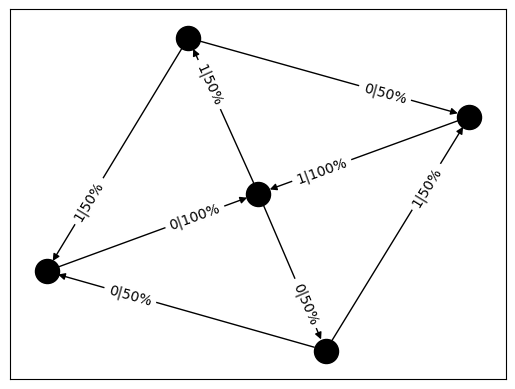

In [72]:
RRXOR = RRXORProcess()


G = epsilon_machine_to_graph(RRXOR.T, RRXOR.state_names)
visualize_graph_with_selective_offset(G)

MSP has shape (2, 36, 36)


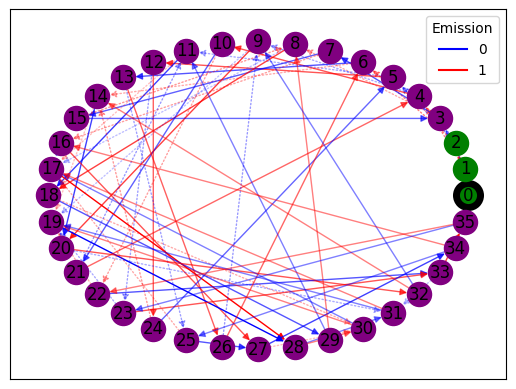

In [73]:
MSP = to_mixed_state_presentation(RRXOR.T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='circular', draw_edge_labels=False, draw_mixed_state=True, draw_color=True)

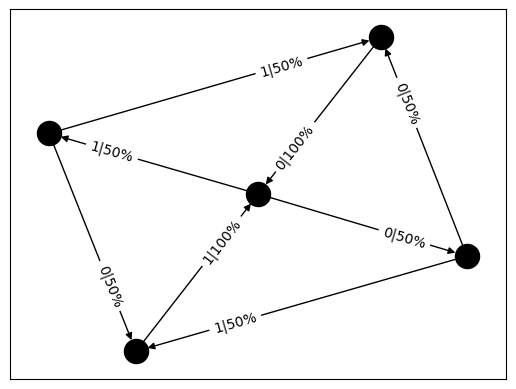

In [74]:
visualize_graph_with_selective_offset(get_recurrent_subgraph(G_MSP))

## Golden Mean Process

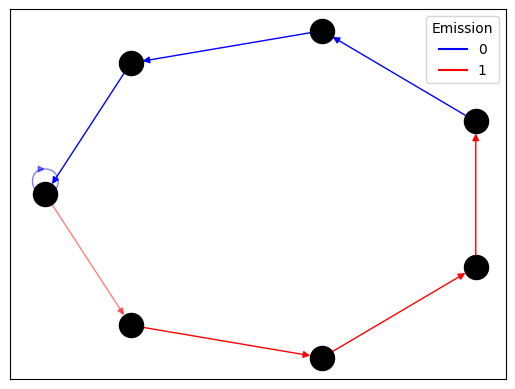

In [78]:
# visualize GM
GM = GoldenMeanProcess(4,3,0.5)
G = epsilon_machine_to_graph(GM.T, state_names=GM.state_names)
visualize_graph_with_selective_offset(G, layout='shell', draw_edge_labels=False, draw_color=True)

In [80]:
# compute MSP of GM
MSP = to_mixed_state_presentation(GM.T, threshold=1e-5)
print("MSP has shape", MSP.shape)

MSP has shape (2, 13, 13)


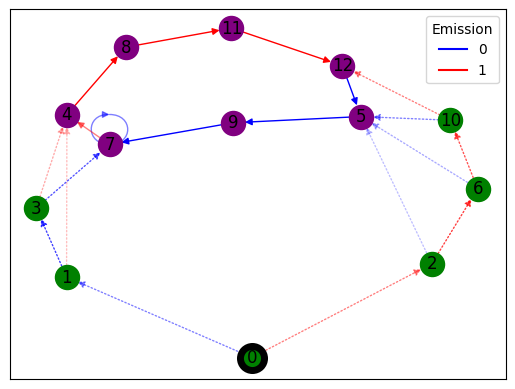

In [81]:
# visualize MSP of GM
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='spectral', draw_edge_labels=False, draw_color=True, draw_mixed_state=True)